In [2]:
#import all required packages
import os
import numpy as np
import matplotlib.pyplot as plt

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import SqrtStretch, simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.io import fits,ascii
from astropy.wcs import WCS
from astropy import units as u
from astropy.stats import sigma_clipped_stats
from astropy.table import join

from photutils.aperture import SkyCircularAperture,SkyCircularAnnulus,aperture_photometry 
from photutils.segmentation import detect_threshold, detect_sources, deblend_sources, SourceCatalog
from photutils.background import Background2D, MedianBackground
from photutils.utils import calc_total_error

In [3]:
#data path
#dpath='E:\Documents\SofiaLegacyProgram\CAL_files\CAL_R'
dpath='C:/Users/mhankins1/Documents/SofiaLegacyProgram/SOFIA_Cycle7_Data/SgrCandNearby'

#file name
fname='F0595_FO_IMA_0701893_FORF253_CAL_0283-0303_FIELD_3.fits'

#Name of field
field='Field3'

#wavelength of data
wavelength=25.2

In [4]:
#change directory to data location
os.chdir(dpath)

#import data - unpack fits file into header, image (data), varance (varmap), and exposure time (tmap)
hdu=fits.open(fname)
header=hdu[0].header
ims=hdu[0].data
#np.shape(ims)
data=ims[0]
varmap=ims[1]
tmap=ims[2]
#wcsmap = WCS(header)
hdu.close()

#hack to make SOFIA wcs header work correctly with astropy.wcs
hdu[0].header['NAXIS']=2
wcsmap=WCS(hdu[0].header)

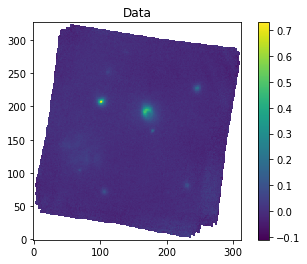

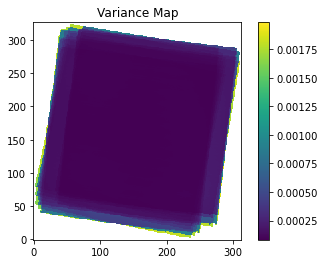

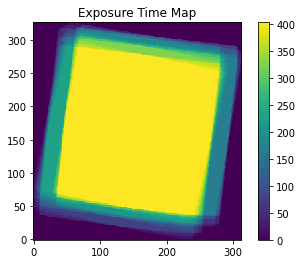

In [5]:
#take a quick look at the maps that were loaded in 
plt.figure()
plt.title('Data')
plt.imshow(data,origin='lower',interpolation='none')
plt.colorbar()
#plt.clim(0.0,0.1)
plt.show()

plt.figure()
plt.title('Variance Map')
plt.imshow(varmap,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Exposure Time Map')
plt.imshow(tmap,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

#create pixel error map by taking sqrt of variance map
errormap=np.sqrt(varmap)

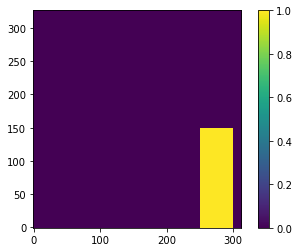

In [6]:
#create mask for edges of field where less integration time was collected
tmapnorm=tmap/np.max(tmap) #normalize the exposure time map
mask=np.where(tmapnorm<0.5,tmapnorm,0).astype('bool') #create mask for any locations with less than 50% of max exposure time -Can be modified as needed

#additional series of masks that can be applied when searching for sources in the segmentation map
mask2=np.zeros(np.shape(mask))  #mask 2 is applied to the first segmentation map instance for source detection
mask2[0:150,250:300]=1 
mask3=np.zeros(np.shape(mask))  #mask 3 is applied to the deblended segmentation map for source detection - this may or may not be needed if the first 2 masks work ok
#mask3[0:330,0:70]=1

#plot any of the masks to verify they are configured as needed
plt.figure()
plt.imshow(mask2,origin='lower',interpolation='none')
plt.colorbar()
plt.show()

In [7]:
#create background model for image using median method
bkg_estimator = MedianBackground()
bkg_data = Background2D(data,(20, 20), filter_size=(3, 3),bkg_estimator=bkg_estimator,edge_method='pad') #smaller box?, 20x20, 25x25?
bkg_rms=bkg_data.background_rms
bkg=bkg_data.background 

#create background subtracted image
data_bkgsub = data - bkg

#set detection threshold for source finding based on modeled background rms
threshold = 3.0*bkg_rms

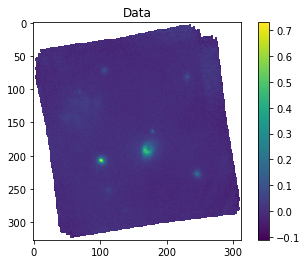

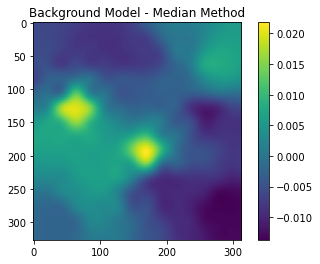

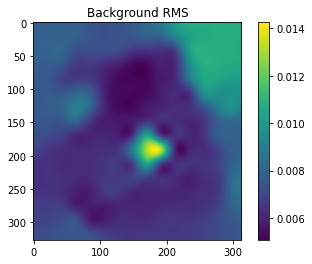

In [8]:
#take a look at data and bakground model images
plt.figure()
plt.title('Data')
plt.imshow(data,interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Background Model - Median Method')
plt.imshow(bkg,interpolation='none')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Background RMS')
plt.imshow(bkg_rms,interpolation='none')
plt.colorbar()
plt.show()

In [9]:
#do source detection. A 3x3 FWHM gaussian is used to smooth image prior to detection
sigma = 3.0 * gaussian_fwhm_to_sigma  # FWHM = 3.
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()
segm = detect_sources(data_bkgsub, threshold, mask=mask, npixels=5, filter_kernel=kernel)

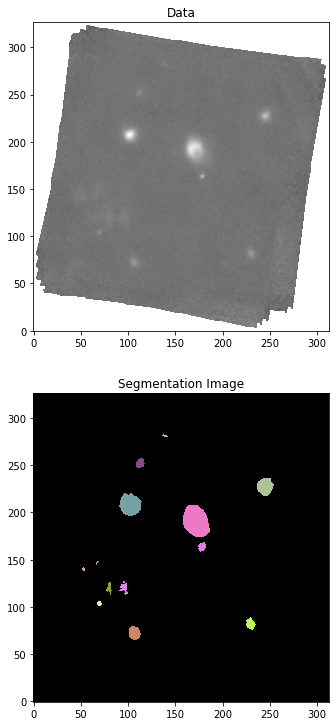

In [10]:
#removed labels that exist in masked region (mask2)
segm.remove_masked_labels(mask2.astype('bool'))

#make plot of segmentation image to show detected sources
norm = ImageNormalize(stretch=SqrtStretch())
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data_bkgsub, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm.make_cmap(seed=123)
ax2.imshow(segm, origin='lower', cmap=cmap, interpolation='nearest')
ax2.set_title('Segmentation Image')
plt.show()

In [11]:
#now lets look at building a catalog and associated table from the seg map
cat = SourceCatalog(data_bkgsub, segm,background=bkg,wcs=wcsmap) #can also take in error and bkg measurements - this is done later

#specify the columns that we want for our table
columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','area',
         'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
         'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']

#create table
tbl = cat.to_table(columns)

#display table below
tbl

label,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,106.65899598550982,72.28266490197771,"266.2632602275237,-29.293716699134546",0.010269643682859299,-0.006039259065108463,-0.8334177509849678,138.0,3.0291517555620353,2.5946200918089812,-66.63320169763222,0.1423200849435648,0.02880680792352863,0.1152057964058468,0.5160639587418456,0.14344994863832106,1.1674740996282413,6.641221655634326,7.895476913759939,nan,1.7149604044659288,6.081368115354866,nan
2,229.83070994054648,81.94225585497519,"266.2331311446372,-29.291654700887506",0.006363478513995479,-0.0015858719959665707,-0.1681024315724565,106.0,2.9406440736778285,2.2254840810292844,-74.6655444825339,0.1958738559618999,0.04400171550863031,0.12167483862144207,0.6536446806832779,0.24319842005023817,1.321350306993786,6.140657093675909,8.247932718240788,nan,2.1204941902535626,5.058556017927308,nan
3,69.85929678541014,103.92029448986325,"266.2722607309958,-29.286966411605604",-0.0062551834181628595,0.009955760309908902,0.19911520619817805,20.0,1.1584980404300593,1.0564055148712845,-60.78482068427581,0.8600967720869394,0.12862894443315961,0.7810576370369123,0.4104677874230421,0.0881249013773695,1.0966414166923524,2.6106185005659794,1.9127755990313005,nan,2.63035987047974,0.9132274066197054,nan
4,80.14292549101287,119.58085136028573,"266.2697448625534,-29.283625812947367",-0.0052520420905620875,0.013494960237340902,0.7287278528164087,54.0,3.1612191631565447,1.4663403252661258,-86.00360842600749,0.46331001969270125,0.050754878787527845,0.10183993623711375,0.8859122926096418,0.5361472110646217,2.1558563920574274,5.802484102658353,10.975911020404226,nan,3.3389451893128124,1.6541855615724863,nan
5,95.37699986836971,120.0994711329348,"266.2660187524897,-29.283515561267656",-0.003421357930204665,0.006205576361620603,0.4157736162285804,67.0,3.3506874423908077,2.0292862456039273,-86.45280658117323,0.24224755796213548,0.018990759023557638,0.08965875905511235,0.7957442437507734,0.3943671916602356,1.6511655019834937,6.522704666301572,11.567699497424977,nan,3.3231002189257697,1.697141443323016,nan
6,53.06869312092769,140.3146211981154,"266.2763659681631,-29.279201665872417",-0.008617277276218716,0.017666327597772473,0.15899694837995226,9.0,0.921174966111332,0.7097824395084712,-70.75690725031282,1.897348311909823,0.5018979098303891,1.2660637991418622,0.6374175214469777,0.22948140622539692,1.2978272141379708,1.93636841537161,2.376827087110413,nan,3.5608947013421384,0.25520212448767965,nan
7,67.67068800709713,146.83755857433115,"266.2727943692164,-29.277810655173656",-0.007285318176986231,0.01688883630700956,0.10133301784205737,6.0,1.2480385865940267,0.4038212584601952,58.38265340033096,4.62337831116749,-4.902028079393282,2.1509102215354075,0.9462060402484176,0.6764352778849186,3.090571782557719,2.1841967783956946,2.5195578606119686,nan,3.805671742074481,0.1667471086521119,nan
8,178.61107692973275,163.52598175080175,"266.24566132863123,-29.2742515292539",0.01576500852327682,0.005400539870832714,0.302430232766632,56.0,1.9321596955505804,1.5010716688970476,63.39246710721193,0.4085163796063516,-0.1409134307715512,0.3031574430259459,0.6296388215767947,0.22311200655217667,1.2871868383008562,4.074062326677002,6.717599169560762,nan,2.587094465155534,3.5208111649718243,nan


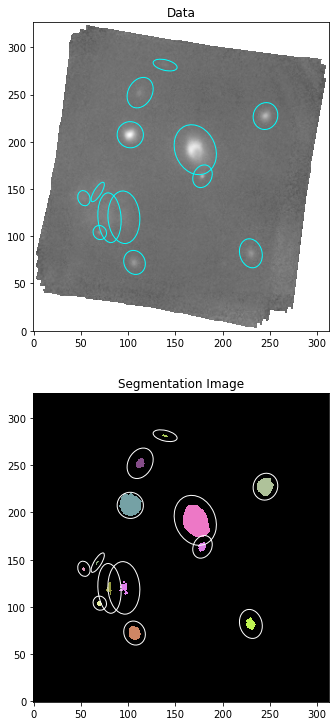

In [12]:
#overplot catalog sources on image - Note some sources may not have apertures plotted if kron aperture fails, but that's ok
norm = simple_norm(data, 'sqrt')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm.make_cmap(seed=123)
ax2.imshow(segm, origin='lower', cmap=cmap,interpolation='nearest')
ax2.set_title('Segmentation Image')
#try-except logic to catch any instances where kron aperture does something weird
for aperture in cat.kron_aperture:
    try:
        aperture.plot(axes=ax1, color='cyan', lw=1.)
        aperture.plot(axes=ax2, color='white', lw=1.)
    except:
        skip=1
plt.show()

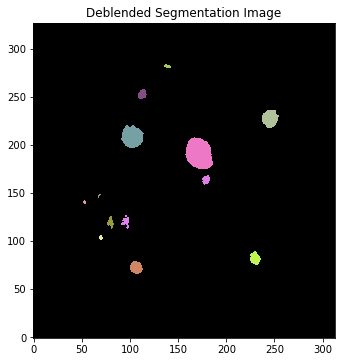

In [13]:
#lets take a look at deblending sources
segm_deblend = deblend_sources(data_bkgsub, segm, npixels=5,filter_kernel=kernel, nlevels=64,contrast=0.001)

#remove any sources that should be masked (mask3)
segm_deblend.remove_masked_labels(mask3.astype('bool'))

#plot the deblended image
plt.figure(figsize=(5.4, 8.5))
plt.imshow(segm_deblend, origin='lower', cmap=cmap, interpolation='nearest')
plt.title('Deblended Segmentation Image')
plt.show()

In [14]:
#now lets look at building a catalog and table from the deblended seg map
catde = SourceCatalog(data_bkgsub, segm_deblend,background=bkg,wcs=wcsmap)

#define which columns we want to have in the table
columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','area',
         'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
         'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']

#create table
tbl_deblend = catde.to_table(columns)

#display table
tbl_deblend

label,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,106.65899598550982,72.28266490197771,"266.2632602275237,-29.293716699134546",0.010269643682859299,-0.006039259065108463,-0.8334177509849678,138.0,3.0291517555620353,2.5946200918089812,-66.63320169763222,0.1423200849435648,0.02880680792352863,0.1152057964058468,0.5160639587418456,0.14344994863832106,1.1674740996282413,6.641221655634326,7.895476913759939,nan,1.7149604044659288,6.081368115354866,nan
2,229.83070994054648,81.94225585497519,"266.2331311446372,-29.291654700887506",0.006363478513995479,-0.0015858719959665707,-0.1681024315724565,106.0,2.9406440736778285,2.2254840810292844,-74.6655444825339,0.1958738559618999,0.04400171550863031,0.12167483862144207,0.6536446806832779,0.24319842005023817,1.321350306993786,6.140657093675909,8.247932718240788,nan,2.1204941902535626,5.058556017927308,nan
3,69.85929678541014,103.92029448986325,"266.2722607309958,-29.286966411605604",-0.0062551834181628595,0.009955760309908902,0.19911520619817805,20.0,1.1584980404300593,1.0564055148712845,-60.78482068427581,0.8600967720869394,0.12862894443315961,0.7810576370369123,0.4104677874230421,0.0881249013773695,1.0966414166923524,2.6106185005659794,1.9127755990313005,nan,2.63035987047974,0.9132274066197054,nan
4,80.14292549101287,119.58085136028573,"266.2697448625534,-29.283625812947367",-0.0052520420905620875,0.013494960237340902,0.7287278528164087,54.0,3.1612191631565447,1.4663403252661258,-86.00360842600749,0.46331001969270125,0.050754878787527845,0.10183993623711375,0.8859122926096418,0.5361472110646217,2.1558563920574274,5.802484102658353,10.975911020404226,nan,3.3389451893128124,1.6541855615724863,nan
5,95.37699986836971,120.0994711329348,"266.2660187524897,-29.283515561267656",-0.003421357930204665,0.006205576361620603,0.4157736162285804,67.0,3.3506874423908077,2.0292862456039273,-86.45280658117323,0.24224755796213548,0.018990759023557638,0.08965875905511235,0.7957442437507734,0.3943671916602356,1.6511655019834937,6.522704666301572,11.567699497424977,nan,3.3231002189257697,1.697141443323016,nan
6,53.06869312092769,140.3146211981154,"266.2763659681631,-29.279201665872417",-0.008617277276218716,0.017666327597772473,0.15899694837995226,9.0,0.921174966111332,0.7097824395084712,-70.75690725031282,1.897348311909823,0.5018979098303891,1.2660637991418622,0.6374175214469777,0.22948140622539692,1.2978272141379708,1.93636841537161,2.376827087110413,nan,3.5608947013421384,0.25520212448767965,nan
7,67.67068800709713,146.83755857433115,"266.2727943692164,-29.277810655173656",-0.007285318176986231,0.01688883630700956,0.10133301784205737,6.0,1.2480385865940267,0.4038212584601952,58.38265340033096,4.62337831116749,-4.902028079393282,2.1509102215354075,0.9462060402484176,0.6764352778849186,3.090571782557719,2.1841967783956946,2.5195578606119686,nan,3.805671742074481,0.1667471086521119,nan
8,178.61107692973275,163.52598175080175,"266.24566132863123,-29.2742515292539",0.01576500852327682,0.005400539870832714,0.302430232766632,56.0,1.9321596955505804,1.5010716688970476,63.39246710721193,0.4085163796063516,-0.1409134307715512,0.3031574430259459,0.6296388215767947,0.22311200655217667,1.2871868383008562,4.074062326677002,6.717599169560762,nan,2.587094465155534,3.5208111649718243,nan


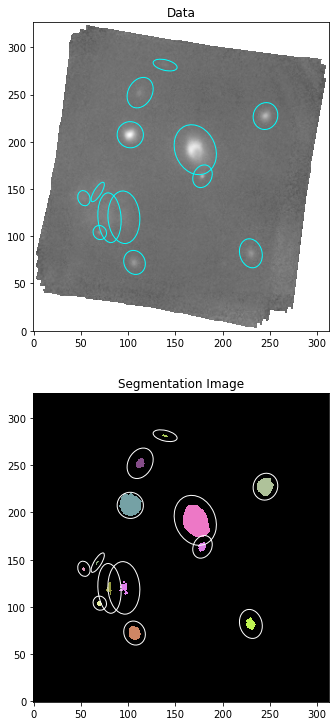

In [15]:
#overplot catalog sources on image - Note some sources may not have apertures plotted if kron aperture fails, but that's ok
norm = simple_norm(data, 'sqrt')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = segm_deblend.make_cmap(seed=123)
ax2.imshow(segm_deblend, origin='lower', cmap=cmap,interpolation='nearest')
ax2.set_title('Segmentation Image')
#try-except logic to catch any instances where kron aperture does something weird
for aperture in catde.kron_aperture:
    try:
        aperture.plot(axes=ax1, color='cyan', lw=1.)
        aperture.plot(axes=ax2, color='white', lw=1.)
    except:
        skip=1
plt.show()

In [16]:
#what if we wanted to include errors? - Not completely sure this is implemented correctly for our observations, but we'll use it for now...
calfactor = header['CALFCTR'] # units are (Me/sec/Jy)
gainfactor=tmap*calfactor*1e6 #gain in electrons/Jy
#errormap=calc_total_error(data,bkg,gainfactor) #use the varmap instead. Its probably more appropriate for our data type. 

#now lets look at building a catalog from the seg map
catwerr = SourceCatalog(data_bkgsub, segm_deblend,background=bkg,error=errormap,wcs=wcsmap)
columns=['label','xcentroid','ycentroid','sky_centroid','background_centroid', 'background_mean','background_sum','background','area',
         'semimajor_sigma','semiminor_sigma','orientation', 'cxx','cxy','cyy','eccentricity','ellipticity','elongation',
         'fwhm','kron_flux','kron_fluxerr','kron_radius','segment_flux','segment_fluxerr']#,'kron_aperture']
tbl2 = catwerr.to_table(columns)

In [17]:
#calculate statistics for background cutouts in table
segbkg_median=[]
segbkg_mean=[]
segbkg_std=[]

#loop through each cutout and use sigma_cliped_stats to get mean, median, and std
for i in range (0,len(tbl2['background'])):
    bkgdata=tbl2['background'][i]
    meansc, median_sigclip, stdsc = sigma_clipped_stats(bkgdata)
    segbkg_median.append(median_sigclip)
    segbkg_mean.append(meansc)
    segbkg_std.append(stdsc)

#add the above calculated information to our table
tbl2['segbkg_mean_sc']=segbkg_mean
tbl2['segbkg_median_sc']=segbkg_median
tbl2['segbkg_std_sc']=segbkg_std  

#remove the 2d background array to tidy up the table
tbl2.remove_column('background')

In [18]:
#calculate noise stats
#sky noise from background
skynoise=np.sqrt(tbl2['segbkg_median_sc']*tbl2['area']/u.pix**2)
#replace any nan values with zero
sna=np.array(skynoise)
masknan=np.isnan(sna)
sna[masknan]=0.0
skynoise=sna**2

#shot noise from the source
sourcenoise=tbl2['segment_flux']

#thermal noise from camera (from error map)
thermalnoise=tbl2['segment_fluxerr']

#total noise
#totalnoise=np.sqrt(sourcenoise+thermalnoise+skynoise) #includes all noise sources
totalnoise=np.sqrt(thermalnoise+skynoise) #no shot noise -> For some reason this seems to work much better for the apertures. Need to think about why this is a bit more...

#calculate SNR for the segments
tbl2['segmentSNR']=tbl2['segment_flux']/ totalnoise 

#display table
tbl2

C:\Users\mhankins1\Anaconda3\lib\site-packages\astropy\units\quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


label,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64
1,106.65899598550982,72.28266490197771,"266.2632602275237,-29.293716699134546",0.010269643682859299,-0.006039259065108463,-0.8334177509849678,138.0,3.0291517555620353,2.5946200918089812,-66.63320169763222,0.1423200849435648,0.02880680792352863,0.1152057964058468,0.5160639587418456,0.14344994863832106,1.1674740996282413,6.641221655634326,7.895476913759939,0.20154817765871152,1.7149604044659288,6.081368115354866,0.1113146,-0.006036972888305697,-0.006101390115378479,0.0005863086515858027,18.22742095163846
2,229.83070994054648,81.94225585497519,"266.2331311446372,-29.291654700887506",0.006363478513995479,-0.0015858719959665707,-0.1681024315724565,106.0,2.9406440736778285,2.2254840810292844,-74.6655444825339,0.1958738559618999,0.04400171550863031,0.12167483862144207,0.6536446806832779,0.24319842005023817,1.321350306993786,6.140657093675909,8.247932718240788,0.23533765470970497,2.1204941902535626,5.058556017927308,0.10102977,-0.0015527613129685028,-0.0016187046786207701,0.000397885429960885,15.91482562719663
3,69.85929678541014,103.92029448986325,"266.2722607309958,-29.286966411605604",-0.0062551834181628595,0.009955760309908902,0.19911520619817805,20.0,1.1584980404300593,1.0564055148712845,-60.78482068427581,0.8600967720869394,0.12862894443315961,0.7810576370369123,0.4104677874230421,0.0881249013773695,1.0966414166923524,2.6106185005659794,1.9127755990313005,0.12291979182415955,2.63035987047974,0.9132274066197054,0.042650882,0.009925449987319842,0.009984817241962301,0.0009635903089455777,1.8550683213682604
4,80.14292549101287,119.58085136028573,"266.2697448625534,-29.283625812947367",-0.0052520420905620875,0.013494960237340902,0.7287278528164087,54.0,3.1612191631565447,1.4663403252661258,-86.00360842600749,0.46331001969270125,0.050754878787527845,0.10183993623711375,0.8859122926096418,0.5361472110646217,2.1558563920574274,5.802484102658353,10.975911020404226,0.3028785598562405,3.3389451893128124,1.6541855615724863,0.069932036,0.013459431456334435,0.013729963315318831,0.0025606510174628126,1.8364541535253425
5,95.37699986836971,120.0994711329348,"266.2660187524897,-29.283515561267656",-0.003421357930204665,0.006205576361620603,0.4157736162285804,67.0,3.3506874423908077,2.0292862456039273,-86.45280658117323,0.24224755796213548,0.018990759023557638,0.08965875905511235,0.7957442437507734,0.3943671916602356,1.6511655019834937,6.522704666301572,11.567699497424977,0.3645746894234942,3.3231002189257697,1.697141443323016,0.07783824,0.006296146161719159,0.006058494700486455,0.00225693667462687,2.440080947766914
6,53.06869312092769,140.3146211981154,"266.2763659681631,-29.279201665872417",-0.008617277276218716,0.017666327597772473,0.15899694837995226,9.0,0.921174966111332,0.7097824395084712,-70.75690725031282,1.897348311909823,0.5018979098303891,1.2660637991418622,0.6374175214469777,0.22948140622539692,1.2978272141379708,1.93636841537161,2.376827087110413,0.11990028710967471,3.5608947013421384,0.25520212448767965,0.028235342,0.017568936848566634,0.017586241911419997,0.0005017341245275125,0.5909237636708863
7,67.67068800709713,146.83755857433115,"266.2727943692164,-29.277810655173656",-0.007285318176986231,0.01688883630700956,0.10133301784205737,6.0,1.2480385865940267,0.4038212584601952,58.38265340033096,4.62337831116749,-4.902028079393282,2.1509102215354075,0.9462060402484176,0.6764352778849186,3.090571782557719,2.1841967783956946,2.5195578606119686

In [19]:
#now lets look at performing some aperture photometry on the data.... Lets get the source centroids from the segmentaion map table
sourcecoords=tbl2['sky_centroid']

In [20]:
#first let's do some simple annulus extractions...   
radii = [2,4,6,8,10] #define aperture radii & construct apertures (line below)
apertures =[SkyCircularAperture(sourcecoords, r=r*u.arcsec) for r in radii] # for pixels: r=r*u.arcsec*0.786

#do aperture photometry on data using defined apertures 
phot_table = aperture_photometry(data_bkgsub, apertures,wcs=wcsmap,error=errormap,method='exact')

#display phot table
phot_table

id,xcenter,ycenter,sky_center,aperture_sum_0,aperture_sum_err_0,aperture_sum_1,aperture_sum_err_1,aperture_sum_2,aperture_sum_err_2,aperture_sum_3,aperture_sum_err_3,aperture_sum_4,aperture_sum_err_4
,pix,pix,"deg,deg",,,,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,106.65899598557337,72.28266490202164,"266.2632602275237,-29.293716699134546",1.90248247367705,0.04373381964228471,4.786616947806887,0.08746130851061203,6.695372249046948,0.13114189694574843,7.655775456715663,0.17472366889931817,8.080971089283661,0.21831830321041812
2,229.8307099405851,81.94225585498785,"266.2331311446372,-29.291654700887506",1.7562264270387733,0.04531418125791667,4.4315742059487455,0.09060817855207366,6.442269163905962,0.13581016891031192,7.527756779984644,0.18094687191028702,8.177043654206441,0.22599894128518938
3,69.8592967853824,103.92029448989516,"266.2722607309958,-29.286966411605604",0.9239073085983147,0.044019999295274476,1.5603304520670254,0.08801790146300421,2.0294137163936767,0.1319997594041362,2.634817183502517,0.17593452001445697,3.524641210961498,0.21985064926384448
4,80.14292549111542,119.58085136029042,"266.2697448625534,-29.283625812947367",0.7295045821898906,0.04396816623067554,2.2954022416231648,0.08787140407255546,4.205963045454137,0.13172268697988948,6.0667991206217735,0.1755569508343145,8.331416600654528,0.21940554647581384
5,95.3769998683367,120.09947113292073,"266.2660187524897,-29.283515561267656",0.5787760514939325,0.04396806322200522,1.9610919529643165,0.08782990419591676,3.622814376255743,0.1316084889047897,5.264687098627666,0.1753540488771174,6.934178013463416,0.21913267073127393
6,53.06869312084579,140.31462119810124,"266.2763659681631,-29.279201665872417",0.5473120686545301,0.043406449031515,1.5230474605953122,0.08678924591391964,2.7289744178860906,0.1306248227332812,3.910891964903869,0.17820384370532089,4.976593943236168,0.22804629504373541
7,67.67068800709761,146.8375585743406,"266.2727943692164,-29.277810655173656",0.47361537897945627,0.04335115795334604,1.4846288273300188,0.08677053401317912,2.8406207353221777,0.1302231863166614,4.356651468370736,0.17372190822539266,5.69255513415183,0.21719267087905647
8,178.6110769297626,163.52598175086348,"266.24566132863123,-29.2742515292539",2.283054868000515,0.042836678471784004,4.00672064316046,0.08574021714564069,5.077392199461624,0.1287404538511646,6.198734552298615,0.17183684616659609,8.186214198327123,0.21486923091192772


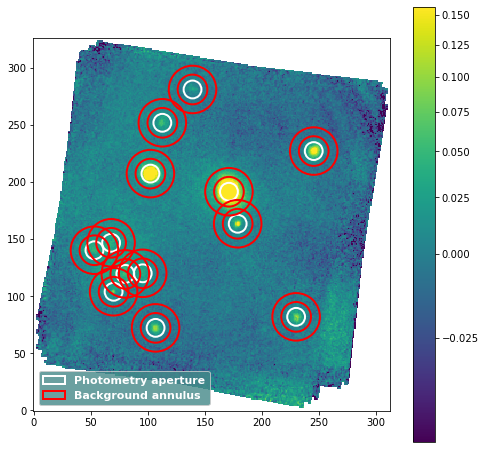

In [21]:
#now try photometry with local background subtraction
aperture2 =SkyCircularAperture(sourcecoords, r=6*u.arcsec) #define aperture
annulus_aperture = SkyCircularAnnulus(sourcecoords, r_in=10*u.arcsec, r_out=16*u.arcsec) #define annulus

#convert to pixel coords for plotting
pix_aperture = aperture2.to_pixel(wcsmap)
pix_annulus_aperture = annulus_aperture.to_pixel(wcsmap)


#show figure with apertures overlayed
plt.figure(figsize=(8,8))
norm = simple_norm(data, 'sqrt', percent=99)
plt.imshow(data, norm=norm, interpolation='nearest',origin='lower')
plt.colorbar()
#plt.xlim(40, 140)
#plt.ylim(50, 125)

ap_patches = pix_aperture.plot(color='white', lw=2,
                           label='Photometry aperture')
ann_patches = pix_annulus_aperture.plot(color='red', lw=2,
                                    label='Background annulus')
handles = (ap_patches[0], ann_patches[0])
plt.legend(loc='best', facecolor='#458989', labelcolor='white',
           handles=handles, prop={'weight': 'bold', 'size': 11})
plt.show()

In [22]:
#now lets do robust statistics on the background annuli

#create lists to store information for later
bkg_median=[]
bkg_mean=[]
bkg_std=[]
appmasks=[]

#create mask array for the annuli
annulus_masks = pix_annulus_aperture.to_mask(method='exact')

#for each of the annuli loop through and calculate stats using sigma cliped stats
for mask in annulus_masks:
    annulus_data = mask.multiply(data_bkgsub)
    
    #this is a bit of debugging to handle if the mask array is the wrong shape
    if np.shape(mask.data)[0]==41:
        maskdata=mask.data[:-1,:]
    else:
        maskdata=mask.data
        
    #do statistics
    annulus_data_1d = annulus_data[maskdata > 0]
    meansc, median_sigclip, stdsc = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(median_sigclip)
    bkg_mean.append(meansc)
    bkg_std.append(stdsc)
    appmasks.append(mask.data)

#store values in numpy arrays
bkg_median = np.array(bkg_median)
bkg_mean = np.array(bkg_mean)
bkg_std = np.array(bkg_std)

In [23]:
#do aperture photometry
phot_table2 = aperture_photometry(data_bkgsub, aperture2,wcs=wcsmap,error=errormap,method='exact') #

#add columns for background information and also background subtracted apertures
phot_table2['ann_bkg_med'] = bkg_median
phot_table2['ann_bkg_mean'] = bkg_mean 
phot_table2['aper_sum_bkgsub_6as'] = (phot_table2['aperture_sum']/pix_aperture.area - phot_table2['ann_bkg_med'])* pix_aperture.area 
phot_table2['aper_sum_bkgsub_err_6as'] = phot_table2['aperture_sum_err'] # should this be modified by bkgsub in some way?
#not sure if the above is right for the error array...

#calculate sky noise for 6 pixel aperture
skynoise=np.sqrt(phot_table2['ann_bkg_med']*pix_aperture.area)
sna=np.array(skynoise)
masknan=np.isnan(sna)
sna[masknan]=0.0
skynoise=sna**2

#store per pix sky noise for later
phot_table2['skynoise_pix']=skynoise/pix_aperture.area

#shot noise from the source
sourcenoise=phot_table2['aper_sum_bkgsub_6as']

#thermal noise from camera (from error map)
thermalnoise=phot_table2['aperture_sum_err']

#compute total noise 
#totalnoise=np.sqrt(sourcenoise+thermalnoise+skynoise) #all noise sources
#totalnoise=np.sqrt(thermalnoise+skynoise) # no shot noise -> For some reason this seems to give more 'reasonable' values. Need to think about why this is a bit more...
totalnoise=np.sqrt((thermalnoise+skynoise)*(1+pix_aperture.area/pix_annulus_aperture.area)) #modified to account for pixel stats

#SNR calc for 6 pixel aperture
phot_table2['aper_snr_6as']=phot_table2['aper_sum_bkgsub_6as']/totalnoise

#display new table
phot_table2

<ipython-input-23-d3b3f743c6c3>:12: RuntimeWarning: invalid value encountered in sqrt
  skynoise=np.sqrt(phot_table2['ann_bkg_med']*pix_aperture.area)


id,xcenter,ycenter,sky_center,aperture_sum,aperture_sum_err,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,aper_snr_6as
,pix,pix,"deg,deg",,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64
1,106.65899598557337,72.28266490202164,"266.2632602275237,-29.293716699134546",6.695372249046948,0.13114189694574843,-0.00011268429998500585,-0.00046633394992962415,6.716979192582073,0.13114189694574843,0.0,16.71917937099673
2,229.8307099405851,81.94225585498785,"266.2331311446372,-29.291654700887506",6.442269163905962,0.13581016891031192,2.054861724664653e-05,1.0381057989287306e-05,6.438329015964925,0.13581016891031192,2.054861724664653e-05,15.524172174847555
3,69.8592967853824,103.92029448989516,"266.2722607309958,-29.286966411605604",2.0294137163936767,0.1319997594041362,0.0017402705355578653,0.0036381265628095652,1.6957210262616567,0.1319997594041362,0.0017402705355578656,2.23983739867678
4,80.14292549111542,119.58085136029042,"266.2697448625534,-29.283625812947367",4.205963045454137,0.13172268697988948,0.007510417614037321,0.008293289279060605,2.765858529267729,0.13172268697988948,0.00751041761403732,1.9885625082831948
5,95.3769998683367,120.09947113292073,"266.2660187524897,-29.283515561267656",3.622814376255743,0.1316084889047897,0.003916961357779863,0.005487459477958785,2.8717464555420604,0.1316084889047897,0.003916961357779863,2.7552246713710944
6,53.06869312084579,140.31462119810124,"266.2763659681631,-29.279201665872417",2.7289744178860906,0.1306248227332812,0.0006857959203929475,0.0013753375791014655,2.597474699375872,0.1306248227332812,0.0006857959203929474,4.573083899115389
7,67.67068800709761,146.8375585743406,"266.2727943692164,-29.277810655173656",2.8406207353221777,0.1302231863166614,0.005252460694653289,0.006111746430356434,1.8334740284168043,0.1302231863166614,0.005252460694653288,1.5496570031475254
8,178.6110769297626,163.52598175086348,"266.24566132863123,-29.2742515292539",5.077392199461624,0.1287404538511646,0.0010467686325039446,0.0021187861440595617,4.876676831483457,0.1287404538511646,0.0010467686325039444,7.658382760273252


In [24]:
#fix id keyword in tbl2 so these can be merged with the phot table results
try:
    tbl2.rename_column('label', 'id')
except:
    print('Do nothing because keyword is already changed.')

In [25]:
#merge the two photometry tables
merged_table = join(phot_table, phot_table2, keys='id')

#merge the segmentation map table with the combined phot table
merged_table_2 = join(tbl2,merged_table, keys='id')

#drop repeat columns
merged_table_2.remove_columns(['xcenter_1','ycenter_1','xcenter_2','ycenter_2','sky_center_1','sky_center_2','aperture_sum','aperture_sum_err'])

#rename some columns to avoid possible confusion
merged_table_2.rename_column('aperture_sum_0', 'aperture_sum_2as')
merged_table_2.rename_column('aperture_sum_err_0', 'aperture_sum_err_2as')
merged_table_2.rename_column('aperture_sum_1', 'aperture_sum_4as')
merged_table_2.rename_column('aperture_sum_err_1', 'aperture_sum_err_4as')
merged_table_2.rename_column('aperture_sum_2', 'aperture_sum_6as')
merged_table_2.rename_column('aperture_sum_err_2', 'aperture_sum_err_6as')
merged_table_2.rename_column('aperture_sum_3', 'aperture_sum_8as')
merged_table_2.rename_column('aperture_sum_err_3', 'aperture_sum_err_8as')
merged_table_2.rename_column('aperture_sum_4', 'aperture_sum_10as')
merged_table_2.rename_column('aperture_sum_err_4', 'aperture_sum_err_10as')


#compute area for the different size apertures 
ap2area=pix_aperture.area*(2./6.)**2
ap4area=pix_aperture.area*(4./6.)**2
#ap6area=pix_aperture.area*(6./6.)**2
ap8area=pix_aperture.area*(8./6.)**2
ap10area=pix_aperture.area*(10./6.)**2


#calculate local bkg subtracted photometry for the other apertures 
merged_table_2['aper_sum_bkgsub_2as']=(merged_table_2['aperture_sum_2as']/ap2area-merged_table_2['ann_bkg_med'])*ap2area
merged_table_2['aper_sum_bkgsub_4as']=(merged_table_2['aperture_sum_4as']/ap4area-merged_table_2['ann_bkg_med'])*ap4area
#merged_table_2['aper_sum_bkgsub_6as']=(merged_table_2['aperture_sum_6as']/ap6area-merged_table_2['ann_bkg_med'])*ap6area
merged_table_2['aper_sum_bkgsub_8as']=(merged_table_2['aperture_sum_8as']/ap8area-merged_table_2['ann_bkg_med'])*ap8area
merged_table_2['aper_sum_bkgsub_10as']=(merged_table_2['aperture_sum_10as']/ap10area-merged_table_2['ann_bkg_med'])*ap10area

#calculate snr for each aperture
merged_table_2['aper_snr_2as']=merged_table_2['aper_sum_bkgsub_2as']/np.sqrt((merged_table_2['aperture_sum_err_2as']+merged_table_2['skynoise_pix']*ap2area)*(1+ap2area/pix_annulus_aperture.area))
merged_table_2['aper_snr_4as']=merged_table_2['aper_sum_bkgsub_4as']/np.sqrt((merged_table_2['aperture_sum_err_4as']+merged_table_2['skynoise_pix']*ap4area)*(1+ap4area/pix_annulus_aperture.area))
#merged_table_2['aper_snr_6as']=merged_table_2['aper_sum_bkgsub_6as']/np.sqrt((merged_table_2['aperture_sum_err_6as']+merged_table_2['skynoise_pix']*ap6area)*(1+ap6area/pix_annulus_aperture.area))
merged_table_2['aper_snr_8as']=merged_table_2['aper_sum_bkgsub_8as']/np.sqrt((merged_table_2['aperture_sum_err_8as']+merged_table_2['skynoise_pix']*ap8area)*(1+ap8area/pix_annulus_aperture.area))
merged_table_2['aper_snr_10as']=merged_table_2['aper_sum_bkgsub_10as']/np.sqrt((merged_table_2['aperture_sum_err_10as']+merged_table_2['skynoise_pix']*ap10area)*(1+ap10area/pix_annulus_aperture.area))

#calculate max snr for all apertures
snr_values=np.array(merged_table_2['aper_snr_2as','aper_snr_4as','aper_snr_6as','aper_snr_8as','aper_snr_10as'])
snr_values.dtype=np.float
snr_values=np.reshape(snr_values, (-1,5))
maxsnr=np.nanmax(snr_values,axis=1)
merged_table_2['aper_snr_max']=maxsnr

#add additonal information for wavelength and which field 
merged_table_2['Field']='C7'+field
merged_table_2['wv']=wavelength

#display table
merged_table_2

id,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR,aperture_sum_2as,aperture_sum_err_2as,aperture_sum_4as,aperture_sum_err_4as,aperture_sum_6as,aperture_sum_err_6as,aperture_sum_8as,aperture_sum_err_8as,aperture_sum_10as,aperture_sum_err_10as,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,aper_snr_6as,aper_sum_bkgsub_2as,aper_sum_bkgsub_4as,aper_sum_bkgsub_8as,aper_sum_bkgsub_10as,aper_snr_2as,aper_snr_4as,aper_snr_8as,aper_snr_10as,aper_snr_max,Field,wv
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,float64
1,106.65899598550982,72.28266490197771,"266.2632602275237,-29.293716699134546",0.010269643682859299,-0.006039259065108463,-0.8334177509849678,138.0,3.0291517555620353,2.5946200918089812,-66.63320169763222,0.1423200849435648,0.02880680792352863,0.1152057964058468,0.5160639587418456,0.14344994863832106,1.1674740996282413,6.641221655634326,7.895476913759939,0.20154817765871152,1.7149604044659288,6.081368115354866,0.1113146,-0.006036972888305697,-0.006101390115378479,0.0005863086515858027,18.22742095163846,1.90248247367705,0.04373381964228471,4.786616947806887,0.08746130851061203,6.695372249046948,0.13114189694574843,7.655775456715663,0.17472366889931817,8.080971089283661,0.21831830321041812,-0.00011268429998500585,-0.00046633394992962415,6.716979192582073,0.13114189694574843,0.0,16.71917937099673,1.904883245180953,4.796220033822498,7.694187800778108,8.14099037688123,8.994188079163223,15.44504540070086,15.500220306807314,13.60111411001949,16.71917937099673,C7Field3,25.2
2,229.83070994054648,81.94225585497519,"266.2331311446372,-29.291654700887506",0.006363478513995479,-0.0015858719959665707,-0.1681024315724565,106.0,2.9406440736778285,2.2254840810292844,-74.6655444825339,0.1958738559618999,0.04400171550863031,0.12167483862144207,0.6536446806832779,0.24319842005023817,1.321350306993786,6.140657093675909,8.247932718240788,0.23533765470970497,2.1204941902535626,5.058556017927308,0.10102977,-0.0015527613129685028,-0.0016187046786207701,0.000397885429960885,15.91482562719663,1.7562264270387733,0.04531418125791667,4.4315742059487455,0.09060817855207366,6.442269163905962,0.13581016891031192,7.527756779984644,0.18094687191028702,8.177043654206441,0.22599894128518938,2.054861724664653e-05,1.0381057989287306e-05,6.438329015964925,0.13581016891031192,2.054861724664653e-05,15.524172174847555,1.7557886328231025,4.429823029086062,7.52075207253391,8.16609879881467,8.105309734097299,13.881743186184417,14.607948903650076,13.095867578352655,15.524172174847555,C7Field3,25.2
3,69.85929678541014,103.92029448986325,"266.2722607309958,-29.286966411605604",-0.0062551834181628595,0.009955760309908902,0.19911520619817805,20.0,1.1584980404300593,1.0564055148712845,-60.78482068427581,0.8600967720869394,0.12862894443315961,0.7810576370369123,0.4104677874230421,0.0881249013773695,1.0966414166923524,2.6106185005659794,1.9127755990313005,0.12291979182415955,2.63035987047974,0.9132274066197054,0.042650882,0.009925449987319842,0.009984817241962301,0.0009635903089455777,1.8550683213682604,0.9239073085983147,0.044019999295274476,1.5603304520670254,0.08801790146300421,2.0294137163936767,0.1319997594041362,2.634817183502517,0.17593452001445697,3.524641210961498,0.21985064926384448,0.0017402705355578653,0.003

In [26]:
#write out the resulting table to file
ascii.write(merged_table_2, field+'_25um_cat.dat', overwrite=True)

In [27]:
#add simple quality cuts to saved sources
snrcut=merged_table_2['aper_snr_max']>=3.0 #max snr in all computed apertures must be gtreq to 3.0
fwhmcut=merged_table_2['fwhm']>=2.5*u.pix #fwhm measures must be greater than 2.5 pixels (~1.9")
keepconditions=(snrcut&fwhmcut) #conditions to keep a source
mtcut=merged_table_2[keepconditions] #apply conditions

#display new table with simple quality cuts
mtcut

id,xcentroid,ycentroid,sky_centroid,background_centroid,background_mean,background_sum,area,semimajor_sigma,semiminor_sigma,orientation,cxx,cxy,cyy,eccentricity,ellipticity,elongation,fwhm,kron_flux,kron_fluxerr,kron_radius,segment_flux,segment_fluxerr,segbkg_mean_sc,segbkg_median_sc,segbkg_std_sc,segmentSNR,aperture_sum_2as,aperture_sum_err_2as,aperture_sum_4as,aperture_sum_err_4as,aperture_sum_6as,aperture_sum_err_6as,aperture_sum_8as,aperture_sum_err_8as,aperture_sum_10as,aperture_sum_err_10as,ann_bkg_med,ann_bkg_mean,aper_sum_bkgsub_6as,aper_sum_bkgsub_err_6as,skynoise_pix,aper_snr_6as,aper_sum_bkgsub_2as,aper_sum_bkgsub_4as,aper_sum_bkgsub_8as,aper_sum_bkgsub_10as,aper_snr_2as,aper_snr_4as,aper_snr_8as,aper_snr_10as,aper_snr_max,Field,wv
,,,"deg,deg",,,,pix2,pix,pix,deg,1 / pix2,1 / pix2,1 / pix2,,,,pix,,,pix,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int32,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,float64
1,106.65899598550982,72.28266490197771,"266.2632602275237,-29.293716699134546",0.010269643682859299,-0.006039259065108463,-0.8334177509849678,138.0,3.0291517555620353,2.5946200918089812,-66.63320169763222,0.1423200849435648,0.02880680792352863,0.1152057964058468,0.5160639587418456,0.14344994863832106,1.1674740996282413,6.641221655634326,7.895476913759939,0.20154817765871152,1.7149604044659288,6.081368115354866,0.1113146,-0.006036972888305697,-0.006101390115378479,0.0005863086515858027,18.22742095163846,1.90248247367705,0.04373381964228471,4.786616947806887,0.08746130851061203,6.695372249046948,0.13114189694574843,7.655775456715663,0.17472366889931817,8.080971089283661,0.21831830321041812,-0.00011268429998500585,-0.00046633394992962415,6.716979192582073,0.13114189694574843,0.0,16.71917937099673,1.904883245180953,4.796220033822498,7.694187800778108,8.14099037688123,8.994188079163223,15.44504540070086,15.500220306807314,13.60111411001949,16.71917937099673,C7Field3,25.2
2,229.83070994054648,81.94225585497519,"266.2331311446372,-29.291654700887506",0.006363478513995479,-0.0015858719959665707,-0.1681024315724565,106.0,2.9406440736778285,2.2254840810292844,-74.6655444825339,0.1958738559618999,0.04400171550863031,0.12167483862144207,0.6536446806832779,0.24319842005023817,1.321350306993786,6.140657093675909,8.247932718240788,0.23533765470970497,2.1204941902535626,5.058556017927308,0.10102977,-0.0015527613129685028,-0.0016187046786207701,0.000397885429960885,15.91482562719663,1.7562264270387733,0.04531418125791667,4.4315742059487455,0.09060817855207366,6.442269163905962,0.13581016891031192,7.527756779984644,0.18094687191028702,8.177043654206441,0.22599894128518938,2.054861724664653e-05,1.0381057989287306e-05,6.438329015964925,0.13581016891031192,2.054861724664653e-05,15.524172174847555,1.7557886328231025,4.429823029086062,7.52075207253391,8.16609879881467,8.105309734097299,13.881743186184417,14.607948903650076,13.095867578352655,15.524172174847555,C7Field3,25.2
3,69.85929678541014,103.92029448986325,"266.2722607309958,-29.286966411605604",-0.0062551834181628595,0.009955760309908902,0.19911520619817805,20.0,1.1584980404300593,1.0564055148712845,-60.78482068427581,0.8600967720869394,0.12862894443315961,0.7810576370369123,0.4104677874230421,0.0881249013773695,1.0966414166923524,2.6106185005659794,1.9127755990313005,0.12291979182415955,2.63035987047974,0.9132274066197054,0.042650882,0.009925449987319842,0.009984817241962301,0.0009635903089455777,1.8550683213682604,0.9239073085983147,0.044019999295274476,1.5603304520670254,0.08801790146300421,2.0294137163936767,0.1319997594041362,2.634817183502517,0.17593452001445697,3.524641210961498,0.21985064926384448,0.0017402705355578653,0.003

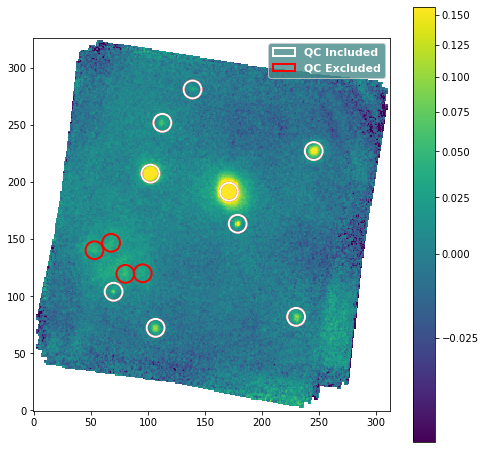

In [28]:
#now let's examine which sources didn't pass the cuts - overplot on the image to see if it looks first order reasonable

#get source coordinates for the snr cut table
cutsc=mtcut['sky_centroid'] 

#Compare which sources are included/excluded
source_aperture =SkyCircularAperture(cutsc, r=6*u.arcsec)

#convert to pixel coords for plotting
pix_aperture_source = source_aperture.to_pixel(wcsmap)


#show figure with apertures overlayed
plt.figure(figsize=(8,8))
norm = simple_norm(data, 'sqrt', percent=99)
plt.imshow(data, norm=norm, interpolation='nearest',origin='lower')
plt.colorbar()
#plt.xlim(40, 140)
#plt.ylim(50, 125)


ap_patches = pix_aperture.plot(color='red', lw=2,
                           label='QC Excluded')
ap_patches_new = pix_aperture_source.plot(color='white', lw=2,
                           label='QC Included')

handles = (ap_patches_new[0],ap_patches[0])
plt.legend(loc='best', facecolor='#458989', labelcolor='white',
          handles=handles, prop={'weight': 'bold', 'size': 11})
plt.show()

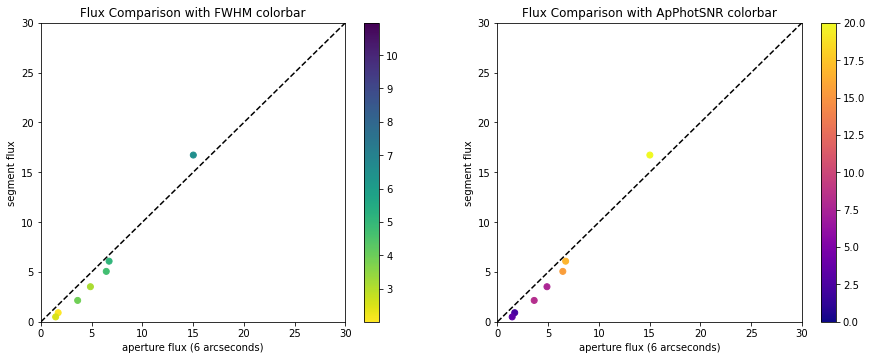

In [29]:
#a few diagnostic plots to examine segment and aperture fluxes
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5.5))

ax1.set_title('Flux Comparison with FWHM colorbar')
p1=ax1.scatter(mtcut['aper_sum_bkgsub_6as'],mtcut['segment_flux'],c=mtcut['fwhm']*0.768, cmap='viridis_r')
fig.colorbar(p1, ax=ax1)
ax1.plot([0,30],[0,30],'k--')
ax1.set_xlabel('aperture flux (6 arcseconds)')
ax1.set_ylabel('segment flux')
ax1.set_xlim(0,30)
ax1.set_ylim(0,30)

ax2.set_title('Flux Comparison with ApPhotSNR colorbar')
p2=ax2.scatter(mtcut['aper_sum_bkgsub_6as'],mtcut['segment_flux'],c=mtcut['aper_snr_6as'], cmap='plasma',vmin=0,vmax=20)
fig.colorbar(p2, ax=ax2)
ax2.plot([0,30],[0,30],'k--')
ax2.set_xlabel('aperture flux (6 arcseconds)')
ax2.set_ylabel('segment flux')
ax2.set_xlim(0,30)
ax2.set_ylim(0,30)


plt.show()

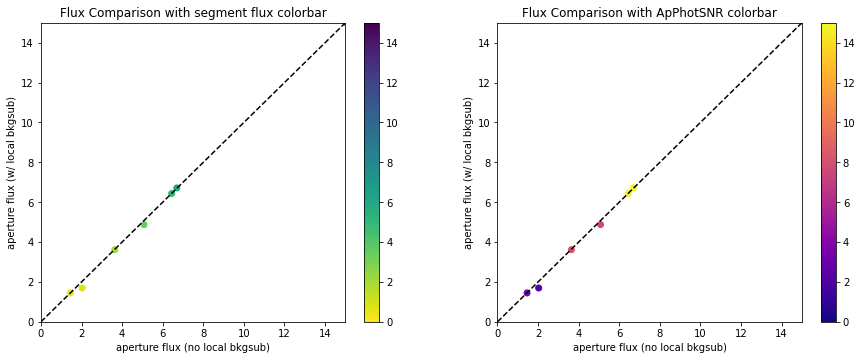

In [30]:
#a few diagnostic plots to examine background contributions to aperture flux
fig, (ax1,ax2) = plt.subplots(1, 2,figsize=(15,5.5))

ax1.set_title('Flux Comparison with segment flux colorbar')
p1=ax1.scatter(mtcut['aperture_sum_6as'],mtcut['aper_sum_bkgsub_6as'],c=mtcut['segment_flux'], cmap='viridis_r',vmin=0,vmax=15)
fig.colorbar(p1, ax=ax1)
ax1.plot([0,30],[0,30],'k--')
ax1.set_xlabel('aperture flux (no local bkgsub)')
ax1.set_ylabel('aperture flux (w/ local bkgsub)')
ax1.set_xlim(0,15)
ax1.set_ylim(0,15)

ax2.set_title('Flux Comparison with ApPhotSNR colorbar')
p2=ax2.scatter(mtcut['aperture_sum_6as'],mtcut['aper_sum_bkgsub_6as'],c=mtcut['aper_snr_6as'], cmap='plasma',vmin=0,vmax=15)
fig.colorbar(p2, ax=ax2)
ax2.plot([0,30],[0,30],'k--')
ax2.set_xlabel('aperture flux (no local bkgsub)')
ax2.set_ylabel('aperture flux (w/ local bkgsub)')
ax2.set_xlim(0,15)
ax2.set_ylim(0,15)


plt.show()

In [31]:
#write out the resulting table to file
ascii.write(mtcut, field+'_25um_cat_qcuts.dat', overwrite=True)